In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt
sns.set_style('ticks')
%matplotlib inline

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
include_inds = np.array([4, 5, 11, 12, 13, 14, 22, 31, 32, 33, 34, 38, 39, 43, 52, 54])
sigma=20;
short_kernel=(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(np.arange(-60,61)**2)/(2*sigma**2))

## Detecting session with valid swim

In [15]:
def valid_swim(row, ismean=True, isplot=True):
    from scipy.stats import ranksums
    
    folder = row['folder']
    fish = row['fish']
    task_type = row['task'][0]
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    if not os.path.exists(swim_dir/'frame_stimParams.npy'):
        return False
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse_series.npy')
    swim_starts = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==1)[0]
    swim_ends   = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==-1)[0]
    swim_ends   = swim_ends[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
    swim_starts = swim_starts[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
    task_period = frame_stimParams[2,swim_starts]
    task_index   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;
    swim_task_index =  task_index[swim_starts]
    swim_count  = np.zeros((len(swim_starts),))
    if task_type == 'S':
        task_period[:] = 1
    
    if len(swim_starts)==0:
        return False
    if (task_period==1).sum()<5:
        return False
    if (task_period==2).sum()==0 and not task_type=='S':
        return False
    
    ind_old=0
    for s in range(len(swim_starts)):
        ind=swim_task_index[s]
        if (ind>ind_old):
            swim_count[s]=1
            ind_old=ind
        elif (ind==ind_old):
            swim_count[s]=swim_count[s-1]+1

    ## mean swim ptterns

    ave_swim=np.empty((len(swim_starts),300))
    ave_swim[:] = 0 #np.nan
    ave_visu=np.empty((len(swim_starts),300))
    ave_visu[:] = 0 #np.nan
    ave_swim_len = np.zeros(len(swim_starts))

    for i in range(len(swim_starts)):
        swim_len = swim_ends[i] - swim_starts[i]
        if swim_len>250:
            swim_len = 250
        ave_swim_len[i] = swim_len
        ave_swim[i,:swim_len+50]=frame_swim_tcourse[2,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*100000
        ave_visu[i,:swim_len+50]=-frame_stimParams[0,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*10000
    
    gain_stat_len = 100
    gain_stat = np.zeros(gain_stat_len)
    gain_sig_stat = np.ones(gain_stat_len)
    if (task_period==2).sum()>0:
        for ntime in range(gain_stat_len):
            val, pval= ranksums(ave_swim[task_period==1, 50+ntime], ave_swim[task_period==2, 50+ntime])
            gain_stat[ntime] = np.sign(val) * pval
            gain_sig_stat[ntime] = (val>0) and (pval<0.05)
    mean_ = gain_sig_stat.mean()
    
    
    if gain_sig_stat.mean()<0.5:
        return False
    
    print(f'{folder} {fish}: average swim difference significance: {mean_}')
    
    if not isplot:
        return True
    
    fig, ax = plt.subplots(1, 5, figsize=(16, 4))
    if ismean:
        ax[0].plot(np.arange(-50,250)/300,np.nanmean(ave_swim[task_period==1,:], axis=0), '-k')
    else:
        ax[0].plot(np.arange(-50,250)/300,ave_swim[task_period==1,:].T, '-k')
    if (task_period==2).sum()>0:
        if ismean:
            ax[0].plot(np.arange(-50,250)/300,np.nanmean(ave_swim[task_period==2,:], axis=0), '-r')
        else:
            ax[0].plot(np.arange(-50,250)/300,ave_swim[task_period==1,:].T, '-r')
    ax[0].set_title('Swim power')
    
    if ismean:
        ax[1].plot(np.arange(-50,250)/300,np.nanmean(ave_visu[task_period==1,:], axis=0), '-k')
    else:
        ax[1].plot(np.arange(-50,250)/300,ave_visu[task_period==1,:].T, '-k')
    if (task_period==2).sum()>0:
        if ismean:
            ax[1].plot(np.arange(-50,250)/300,np.nanmean(ave_visu[task_period==2,:], axis=0), '-r')
        else:
            ax[1].plot(np.arange(-50,250)/300,ave_visu[task_period==1,:].T, '-r')


    ax[1].set_title('Visual velocity')
    tot_swim_power = ave_swim[:,50:].sum(axis=1)
    ax[2].plot(ave_swim_len, tot_swim_power, 'o')
    ax[2].set_ylabel('Total swim power')
    ax[2].set_xlabel('Swim length')
    ax[2].set_title(row['task'])
    ax[3].imshow(ave_swim[:,50:200], aspect='auto')
    ax[3].set_ylabel('Swim index')
    ax[3].set_xlabel('Frame from swim bout onset')
    
    ax[4].imshow(task_period[:, np.newaxis], aspect='auto', cmap=plt.cm.Set1)
    plt.show()
    plt.savefig(f'swim_power/{folder}_{fish}.png')
    # plt.close()
    return True

03152018 Fish1-1: average swim difference significance: 0.64


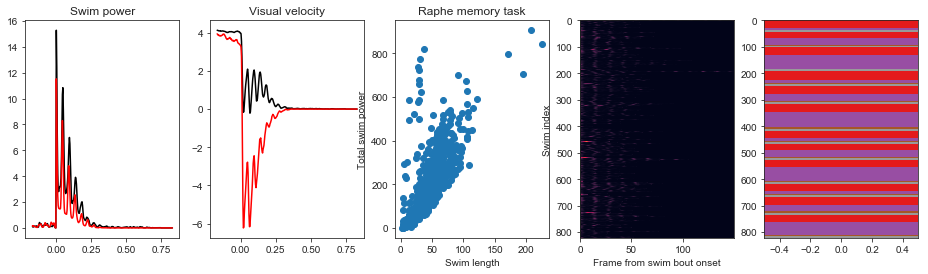

03152018 Fish4-1: average swim difference significance: 0.71


<Figure size 432x288 with 0 Axes>

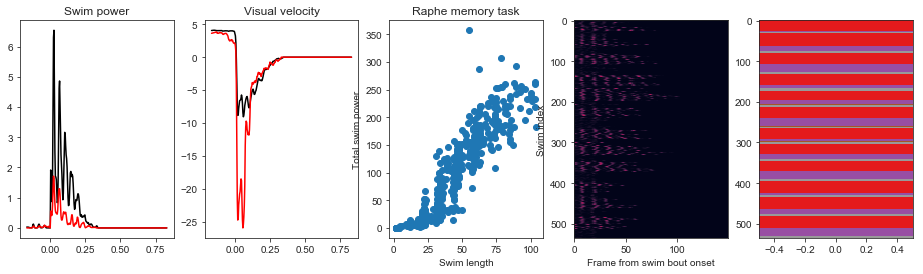

03152018 Fish4-2: average swim difference significance: 0.87


<Figure size 432x288 with 0 Axes>

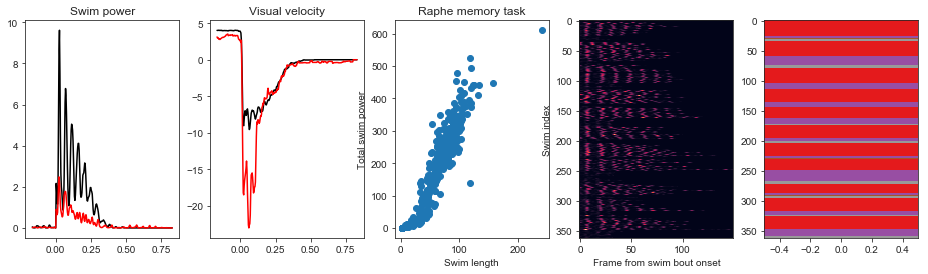

04052018 Fish4-1: average swim difference significance: 0.53


<Figure size 432x288 with 0 Axes>

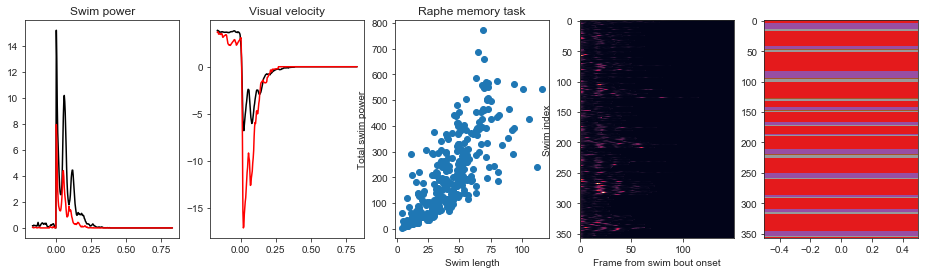

04052018 Fish4-2: average swim difference significance: 0.56


<Figure size 432x288 with 0 Axes>

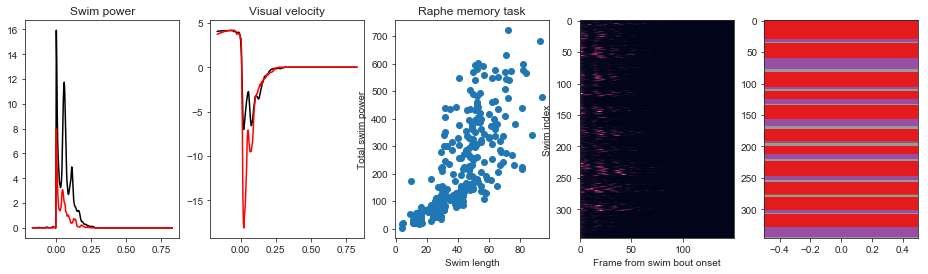

04122018 Fish2-1: average swim difference significance: 0.87


<Figure size 432x288 with 0 Axes>

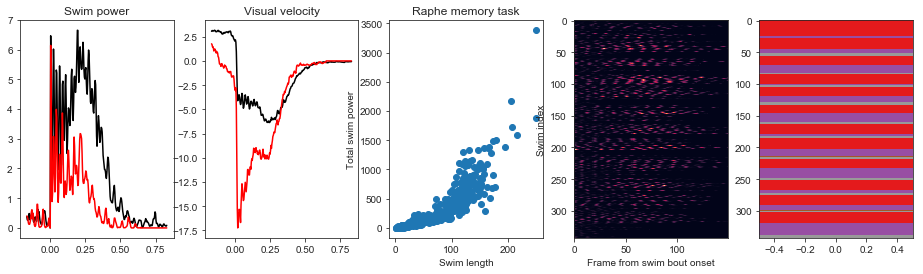

04122018 Fish2-2: average swim difference significance: 0.56


<Figure size 432x288 with 0 Axes>

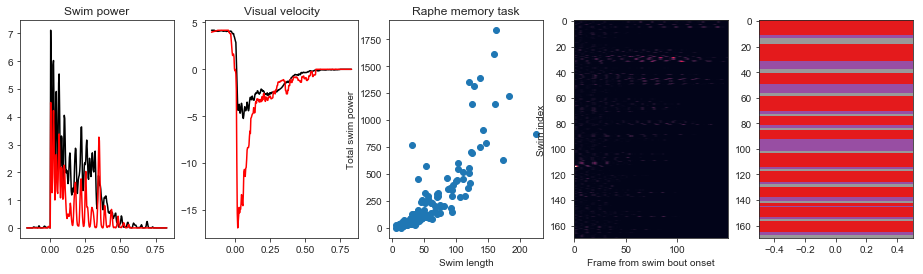

04122018 Fish4-1: average swim difference significance: 0.65


<Figure size 432x288 with 0 Axes>

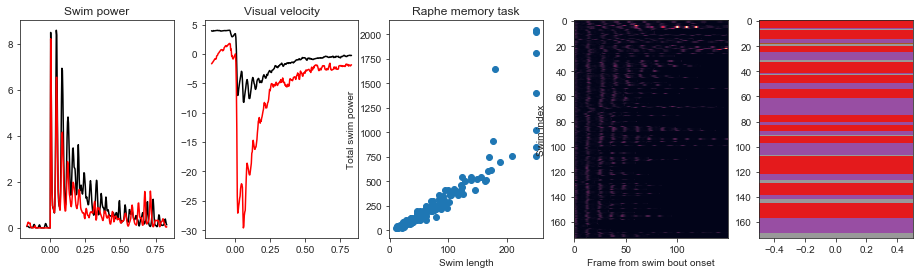

04192018 Fish1-1: average swim difference significance: 0.94


<Figure size 432x288 with 0 Axes>

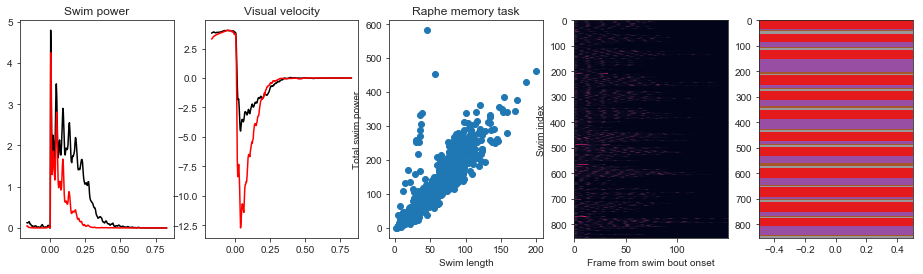

04192018 Fish1-2: average swim difference significance: 0.51


<Figure size 432x288 with 0 Axes>

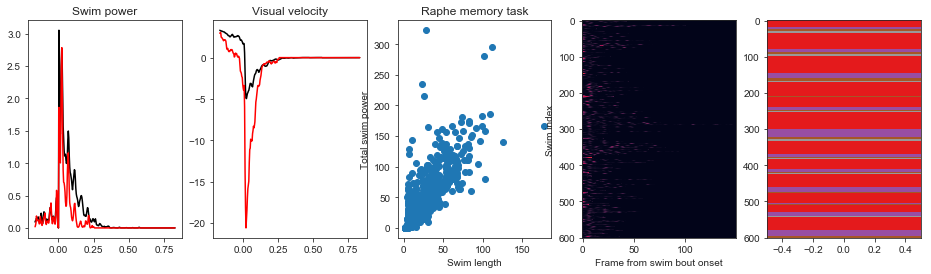

04192018 Fish2-2: average swim difference significance: 0.87


<Figure size 432x288 with 0 Axes>

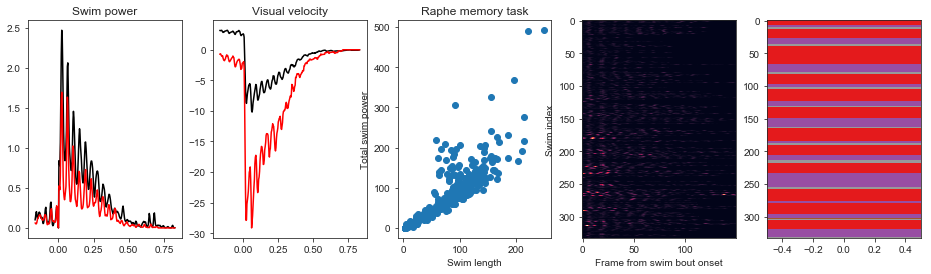

07262018 Fish2-1: average swim difference significance: 0.7


<Figure size 432x288 with 0 Axes>

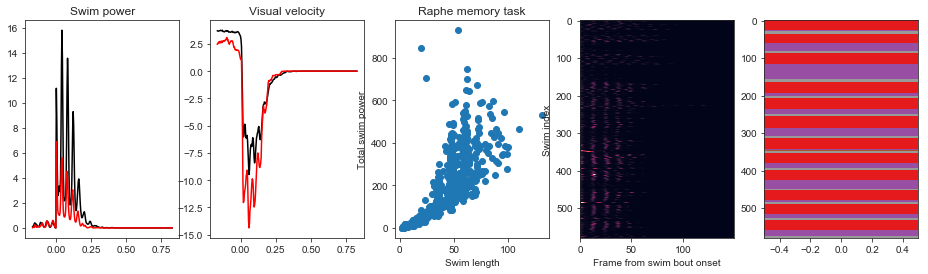

07262018 Fish2-2: average swim difference significance: 0.55


<Figure size 432x288 with 0 Axes>

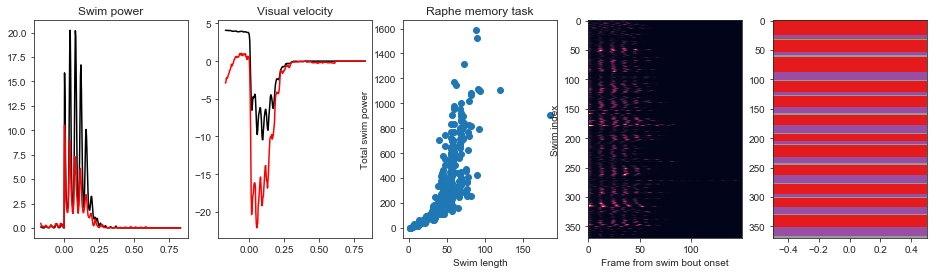

10182018 Fish3-1: average swim difference significance: 0.59


<Figure size 432x288 with 0 Axes>

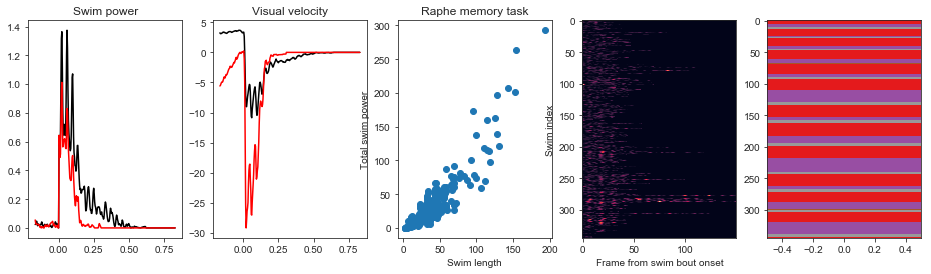

11222018 Fish1-1: average swim difference significance: 0.77


<Figure size 432x288 with 0 Axes>

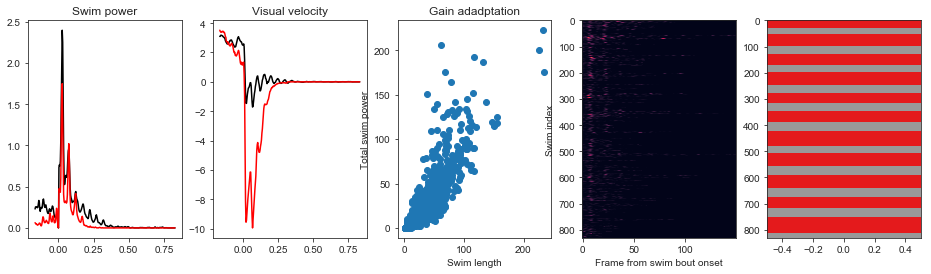

11222018 Fish1-2: average swim difference significance: 0.77


<Figure size 432x288 with 0 Axes>

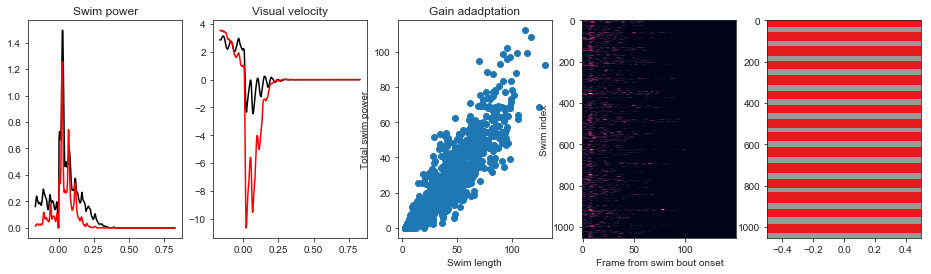

11222018 Fish1-3: average swim difference significance: 1.0


<Figure size 432x288 with 0 Axes>

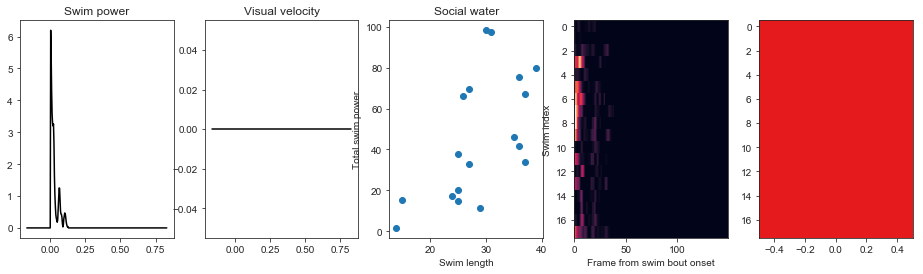

11222018 Fish2-1: average swim difference significance: 0.66


<Figure size 432x288 with 0 Axes>

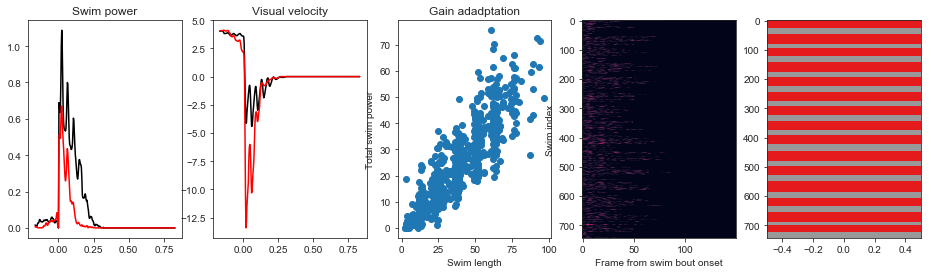

11222018 Fish2-2: average swim difference significance: 0.74


<Figure size 432x288 with 0 Axes>

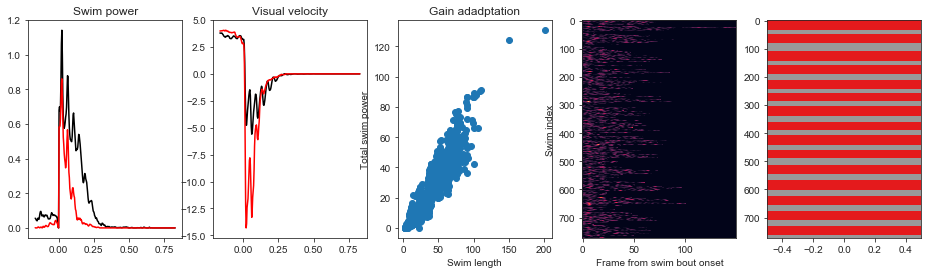

<Figure size 432x288 with 0 Axes>

In [16]:
# remove figures in the swim_power folder if any
import glob
if not os.path.isdir('swim_power'):
    os.mkdir('swim_power')
files = glob.glob('swim_power/*.png')
for f in files:
    os.remove(f)
plt.close('all')
valid_swim_list = []
for index, row in dat_xls_file.iterrows():
    valid_swim_list.append(valid_swim(row, isplot=True))

In [17]:
swim_xls_file = dat_xls_file[valid_swim_list]

## Swim pattern analysis

In [84]:
def swim_pca(row, ismean=True, isplot=True):
    from scipy.stats import ranksums
    from sklearn.decomposition import PCA, NMF
    
    folder = row['folder']
    fish = row['fish']
    task_type = row['task'][0]
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    print(swim_dir)
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse_series.npy')
    swim_starts = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==1)[0]
    swim_ends   = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==-1)[0]
    swim_ends   = swim_ends[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
    swim_starts = swim_starts[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
    task_period = frame_stimParams[2,swim_starts]
    task_index   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;
    swim_task_index =  task_index[swim_starts]
    swim_count  = np.zeros((len(swim_starts),))    
    ind_old=0
    for s in range(len(swim_starts)):
        ind=swim_task_index[s]
        if (ind>ind_old):
            swim_count[s]=1
            ind_old=ind
        elif (ind==ind_old):
            swim_count[s]=swim_count[s-1]+1

    ave_swim=np.empty((len(swim_starts),300))
    ave_swim[:] = 0 #np.nan
    ave_visu=np.empty((len(swim_starts),300))
    ave_visu[:] = 0 #np.nan
    ave_swim_len = np.zeros(len(swim_starts))

    for i in range(len(swim_starts)):
        swim_len = swim_ends[i] - swim_starts[i]
        if swim_len>250:
            swim_len = 250
        ave_swim_len[i] = swim_len
        ave_swim[i,:swim_len+50]=frame_swim_tcourse[2,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*100000
        ave_visu[i,:swim_len+50]=-frame_stimParams[0,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*10000
    
    num_comp = 10
    pca = PCA()#NMF(n_components=num_comp)#PCA()
    pca.fit(ave_swim[:, 50:200])
    x = pca.transform(ave_swim[:, 50:200]) 
    
#     c_1 = 0
#     c_2 = 1
#     plt.plot(x_[task_period==1, c_1], x_[task_period==1, c_2], '.')
#     plt.plot(x_[task_period==2, c_1], x_[task_period==2, c_2], '.')
#     plt.xlabel('Component %d'%(c_1))
#     plt.ylabel('Component %d'%(c_2))
#     plt.show()
    
    plt.boxplot(x_[task_period==1, :])
    plt.ylim([x_.min(), x_.max()])
    plt.show()
    
    plt.boxplot(x_[task_period==2, :])
    plt.ylim([x_.min(), x_.max()])
    plt.show()
    
    return pca, x

/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/03152018/Fish1-1/swim


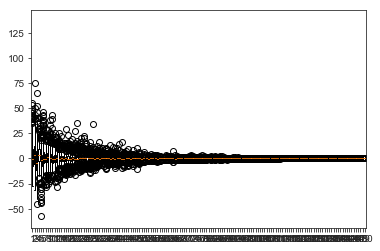

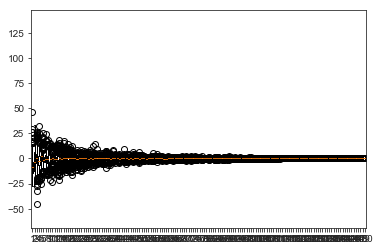

In [85]:
count = -1
for index, row in swim_xls_file.iterrows():
    count += 1
    if count != 0:        
        continue
    pca_, x_ = swim_pca(row)

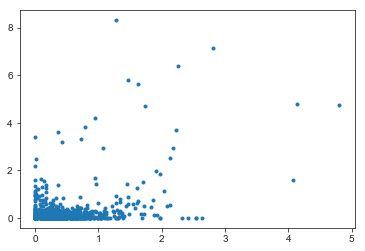

In [74]:
plt.plot(x_[:, 0], x_[:, 1], '.')

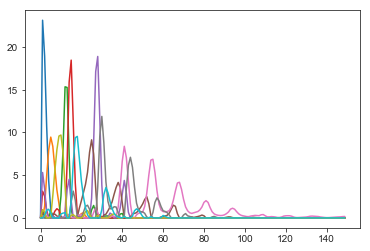

In [73]:
plt.plot(pca_.components_.T)